In [12]:
from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import col, when, avg,count
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
# Initialize Spark session with local file system configuration
spark = SparkSession.builder \
    .appName("CSV to DataFrame") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .getOrCreate()

# This config is to ensure output can be readable and not overlapping
spark.conf.set("spark.sql.debug.maxToStringFields", "100") 
 
# Define the path to the CSV file
csv_path = "survey_results_public.csv"
# Read the CSV file into a DataFrame
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Count the number of rows and columns
num_rows = df.count()
num_columns = len(df.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

#output : Number of rows: 89184 / Number of columns: 84

Number of rows: 89184
Number of columns: 84


In [14]:
for col in df.columns:
    print(col)

ResponseId
Q120
MainBranch
Age
Employment
RemoteWork
CodingActivities
EdLevel
LearnCode
LearnCodeOnline
LearnCodeCoursesCert
YearsCode
YearsCodePro
DevType
OrgSize
PurchaseInfluence
TechList
BuyNewTool
Country
Currency
CompTotal
LanguageHaveWorkedWith
LanguageWantToWorkWith
DatabaseHaveWorkedWith
DatabaseWantToWorkWith
PlatformHaveWorkedWith
PlatformWantToWorkWith
WebframeHaveWorkedWith
WebframeWantToWorkWith
MiscTechHaveWorkedWith
MiscTechWantToWorkWith
ToolsTechHaveWorkedWith
ToolsTechWantToWorkWith
NEWCollabToolsHaveWorkedWith
NEWCollabToolsWantToWorkWith
OpSysPersonal use
OpSysProfessional use
OfficeStackAsyncHaveWorkedWith
OfficeStackAsyncWantToWorkWith
OfficeStackSyncHaveWorkedWith
OfficeStackSyncWantToWorkWith
AISearchHaveWorkedWith
AISearchWantToWorkWith
AIDevHaveWorkedWith
AIDevWantToWorkWith
NEWSOSites
SOVisitFreq
SOAccount
SOPartFreq
SOComm
SOAI
AISelect
AISent
AIAcc
AIBen
AIToolInterested in Using
AIToolCurrently Using
AIToolNot interested in Using
AINextVery different
AINe

In [21]:
selected_columns = ['AISearchHaveWorkedWith','AISearchWantToWorkWith','AIDevHaveWorkedWith','AIDevWantToWorkWith']
df_AI = df.select(*selected_columns)

In [23]:
df_AI.show()

+----------------------+----------------------+--------------------+--------------------+
|AISearchHaveWorkedWith|AISearchWantToWorkWith| AIDevHaveWorkedWith| AIDevWantToWorkWith|
+----------------------+----------------------+--------------------+--------------------+
|                    NA|                    NA|                  NA|                  NA|
|               ChatGPT|      ChatGPT;Neeva AI|      GitHub Copilot|      GitHub Copilot|
|                    NA|                    NA|                  NA|                  NA|
|                    NA|                    NA|                  NA|                  NA|
|               ChatGPT|               ChatGPT|                  NA|                  NA|
|  ChatGPT;Google Ba...|                    NA|GitHub Copilot;Ta...|                  NA|
|               ChatGPT|                    NA|      GitHub Copilot|                  NA|
|  Bing AI;ChatGPT;G...|  ChatGPT;Neeva AI;...|      GitHub Copilot|      GitHub Copilot|
|         

In [24]:
# Filtering out NA values
df_cleaned = df_AI.filter((df['AISearchHaveWorkedWith'] != 'NA') & 
                       (df['AISearchWantToWorkWith'] != 'NA') &
                       (df['AIDevHaveWorkedWith'] != 'NA') &
                       (df['AIDevWantToWorkWith'] != 'NA'))


In [26]:
from pyspark.sql.functions import split, explode

# Splitting and exploding the columns
df_exploded = df_cleaned.withColumn('AISearchHaveWorkedWith', explode(split(df['AISearchHaveWorkedWith'], ';'))) \
                .withColumn('AISearchWantToWorkWith', explode(split(df['AISearchWantToWorkWith'], ';'))) \
                .withColumn('AIDevHaveWorkedWith', explode(split(df['AIDevHaveWorkedWith'], ';'))) \
                .withColumn('AIDevWantToWorkWith', explode(split(df['AIDevWantToWorkWith'], ';')))


In [28]:
df_exploded.count()

465364

In [17]:
from pyspark.sql.functions import col

# Counting occurrences in each column
aisearch_have_counts = df_exploded.groupBy('AISearchHaveWorkedWith').count().orderBy(col('count').desc())
aisearch_want_counts = df_exploded.groupBy('AISearchWantToWorkWith').count().orderBy(col('count').desc())
aidev_have_counts = df_exploded.groupBy('AIDevHaveWorkedWith').count().orderBy(col('count').desc())
aidev_want_counts = df_exploded.groupBy('AIDevWantToWorkWith').count().orderBy(col('count').desc())


In [18]:
aisearch_have_counts_pd = aisearch_have_counts.toPandas()
aisearch_want_counts_pd = aisearch_want_counts.toPandas()
aidev_have_counts_pd = aidev_have_counts.toPandas()
aidev_want_counts_pd = aidev_want_counts.toPandas()


In [31]:
aidev_have_counts_pd

,AIDevHaveWorkedWith,count
0,GitHub Copilot,114033
1,Tabnine,60938
2,AWS CodeWhisperer,46313
3,Whispr AI,38036
4,Synk Code,36598
5,Adrenaline,36072
6,Replit Ghostwriter,35703
7,Rubber Duck.AI,34542
8,Mintlify,33904
9,Codeium,29225


In [32]:
aidev_want_counts_pd

,AIDevWantToWorkWith,count
0,GitHub Copilot,107112
1,AWS CodeWhisperer,53445
2,Tabnine,47338
3,Whispr AI,40409
4,Replit Ghostwriter,39529
5,Synk Code,37166
6,Rubber Duck.AI,36632
7,Adrenaline,36553
8,Mintlify,36419
9,Codeium,30761


In [29]:
aisearch_have_counts_pd

,AISearchHaveWorkedWith,count
0,ChatGPT,91657
1,Bing AI,60371
2,Google Bard AI,45179
3,WolframAlpha,43365
4,You.com,37950
5,Phind,34012
6,Quora Poe,31752
7,Perplexity AI,30803
8,Andi,30715
9,Neeva AI,30690


In [30]:
aisearch_want_counts_pd

,AISearchWantToWorkWith,count
0,ChatGPT,80627
1,Bing AI,55128
2,Google Bard AI,53125
3,WolframAlpha,43252
4,You.com,36243
5,Phind,35547
6,Perplexity AI,34269
7,Neeva AI,32207
8,Quora Poe,32142
9,Andi,31911


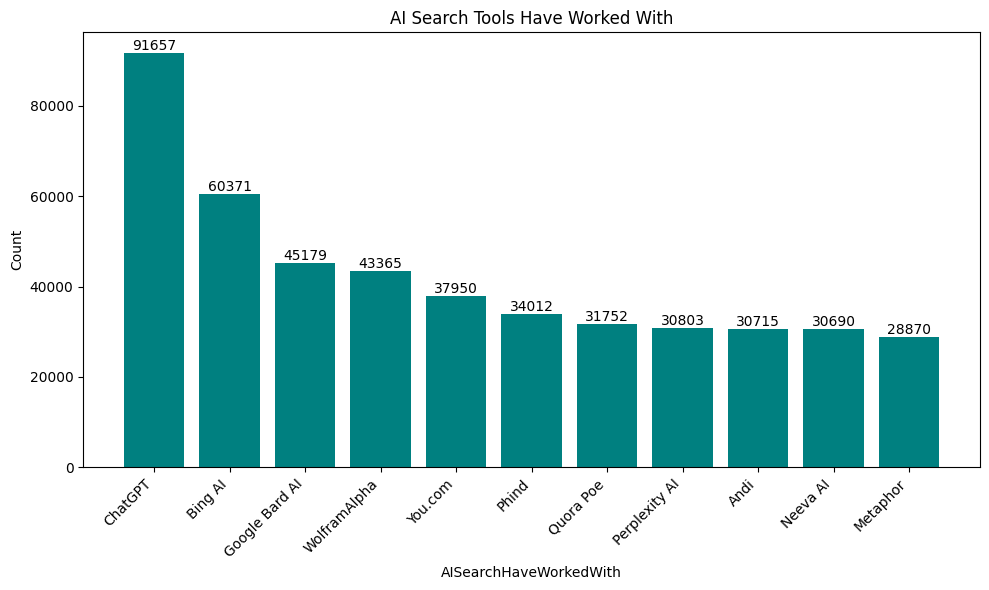

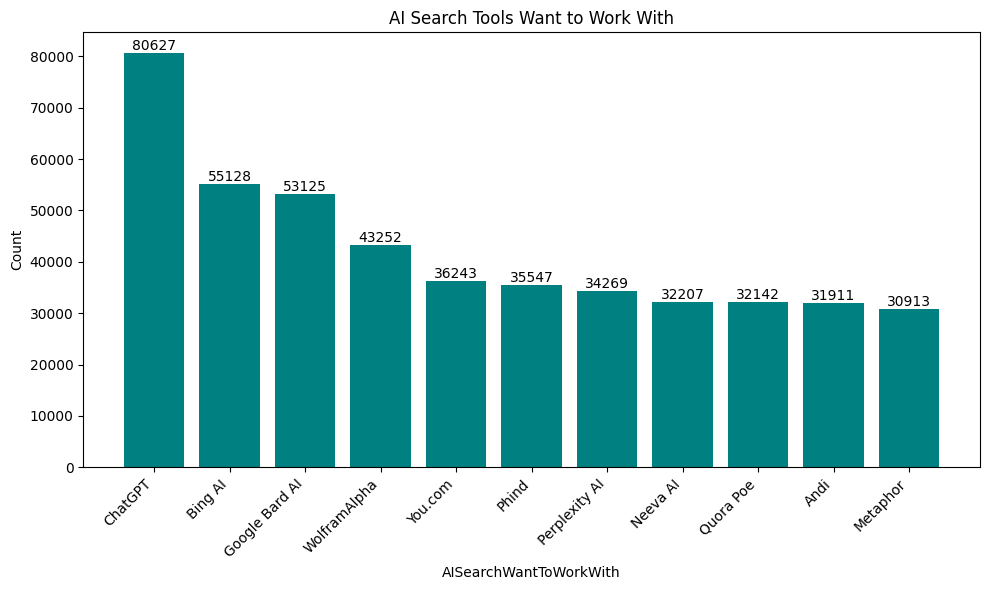

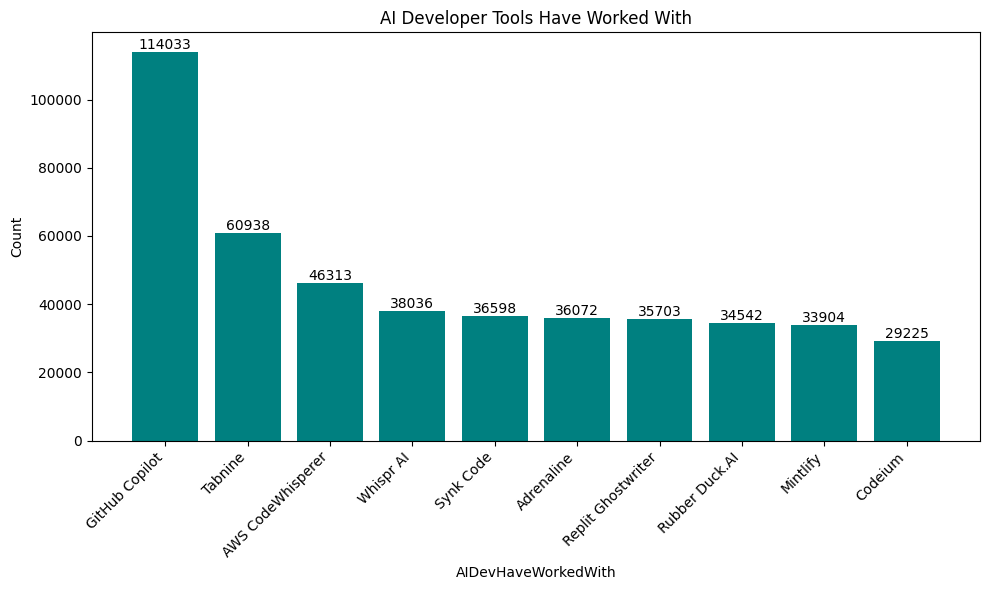

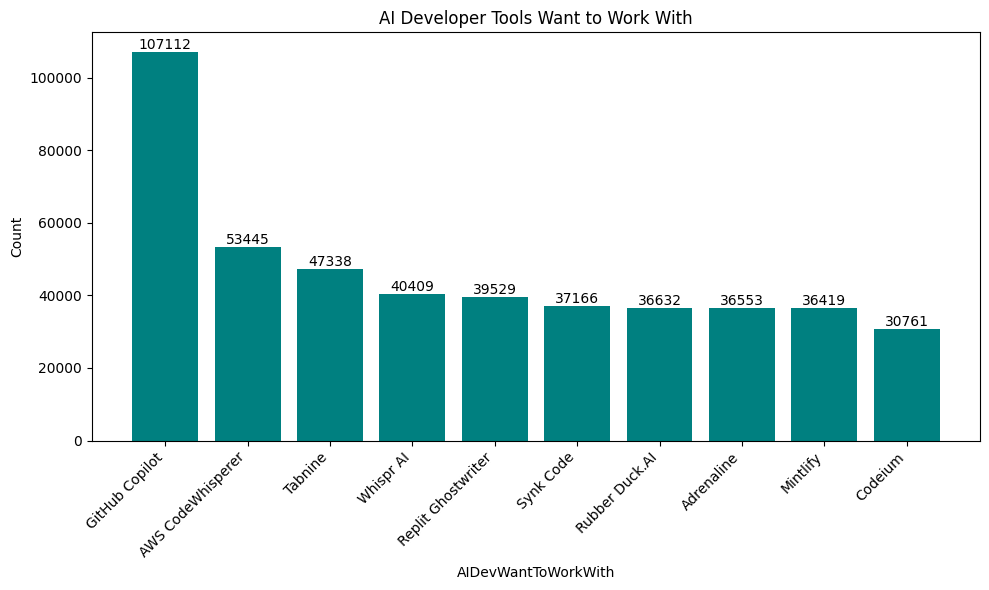

In [19]:
import matplotlib.pyplot as plt

# Function to create bar charts with user counts on top
def plot_bar_chart(df, column, title):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df[column], df['count'], color='teal')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    
    # Adding text annotations on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', color='black')
    
    plt.tight_layout()
    plt.show()

# Plotting the data with user counts on top
plot_bar_chart(aisearch_have_counts_pd, 'AISearchHaveWorkedWith', 'AI Search Tools Have Worked With')
plot_bar_chart(aisearch_want_counts_pd, 'AISearchWantToWorkWith', 'AI Search Tools Want to Work With')
plot_bar_chart(aidev_have_counts_pd, 'AIDevHaveWorkedWith', 'AI Developer Tools Have Worked With')
plot_bar_chart(aidev_want_counts_pd, 'AIDevWantToWorkWith', 'AI Developer Tools Want to Work With')
